In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('ncr_ride_bookings.csv')

In [3]:
df.head(5)

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


In [4]:
df.isnull().sum()

Date                                      0
Time                                      0
Booking ID                                0
Booking Status                            0
Customer ID                               0
Vehicle Type                              0
Pickup Location                           0
Drop Location                             0
Avg VTAT                              10500
Avg CTAT                              48000
Cancelled Rides by Customer          139500
Reason for cancelling by Customer    139500
Cancelled Rides by Driver            123000
Driver Cancellation Reason           123000
Incomplete Rides                     141000
Incomplete Rides Reason              141000
Booking Value                         48000
Ride Distance                         48000
Driver Ratings                        57000
Customer Rating                       57000
Payment Method                        48000
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

Data Cleaning

In [6]:
df['Vehicle Type'].unique()

array(['eBike', 'Go Sedan', 'Auto', 'Premier Sedan', 'Bike', 'Go Mini',
       'Uber XL'], dtype=object)

In [7]:
df['Incomplete Rides Reason'].unique()

array([nan, 'Vehicle Breakdown', 'Other Issue', 'Customer Demand'],
      dtype=object)

In [8]:
df['Driver Cancellation Reason'].unique()
df['Reason for cancelling by Customer'].unique()
df['Cancelled Rides by Customer'].unique()
df['Cancelled Rides by Driver'].unique()

array([nan,  1.])

In [9]:
status_col = "Booking Status"
col_customer = "Reason for cancelling by Customer"
col_driver = "Driver Cancellation Reason"
col_incomplete = "Incomplete Rides Reason"

# function to pull the correct reason depending on status
def choose_reason(row):
    s = row[status_col]
    if s == "Cancelled by Customer":
        return row.get(col_customer, np.nan)
    if s == "Cancelled by Driver":
        return row.get(col_driver, np.nan)
    if s in ["No Driver Found", "Incomplete"]:
        return row.get(col_incomplete, np.nan)
    return np.nan

df['Unified_Incomplete_Reason'] = df.apply(choose_reason, axis=1)

# flag whether this booking is an incomplete-type status
incomplete_statuses = ["Cancelled by Driver", "Cancelled by Customer", "No Driver Found", "Incomplete"]
df['is_incomplete'] = df[status_col].isin(incomplete_statuses)

# Create a cleaned reason column:
# - Completed: "Not Applicable"
# - Incomplete + missing reason: "Unknown"
# - Otherwise: use the unified reason
df['Incomplete_Ride_Reason_Clean'] = df['Unified_Incomplete_Reason'].copy()
df.loc[~df['is_incomplete'], 'Incomplete_Ride_Reason_Clean'] = 'Not Applicable'
mask_unknown = df['is_incomplete'] & df['Incomplete_Ride_Reason_Clean'].isna()
df.loc[mask_unknown, 'Incomplete_Ride_Reason_Clean'] = 'Unknown'

# A missingness flag (useful feature)
df['reason_missing_flag'] = df['Unified_Incomplete_Reason'].isna().astype(int)

# Quick sanity counts
print("Total rows:", len(df))
print("Completed rows:", df[status_col].eq("Completed").sum())
print("Incomplete rows:", df['is_incomplete'].sum())
print("Non-null unified reasons:", df['Unified_Incomplete_Reason'].notna().sum())
print("Remaining nulls in unified reason:", df['Unified_Incomplete_Reason'].isna().sum())

Total rows: 150000
Completed rows: 93000
Incomplete rows: 57000
Non-null unified reasons: 46500
Remaining nulls in unified reason: 103500


In [10]:
df = df.drop(columns=['Reason for cancelling by Customer','Driver Cancellation Reason','Incomplete Rides Reason','Cancelled Rides by Customer'])
df =df.drop(columns=['Cancelled Rides by Driver','Incomplete Rides','Booking ID','Unified_Incomplete_Reason','reason_missing_flag'])

In [11]:
df.rename(columns={'is_incomplete':'Ride_status','Incomplete_Ride_Reason_Clean':'incomplete_ride_reason'},inplace=True)
df['Ride_status'] = df['Ride_status'].map({True: "Incomplete", False: "Complete"})


In [12]:
df['Hour'] = pd.to_datetime(df['Time'], format="%H:%M:%S").dt.hour
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df['Day_Name'] = df['Date'].dt.day_name()

In [13]:
def getTimebyZone(Hour):
    if Hour >=6 and Hour <=12:
        return 'Morning'
    elif Hour>12 and Hour<=16:
        return 'Afternoon'
    elif Hour >16 and Hour<=20:
        return 'Evenings'
    elif Hour >20 and Hour<=24:
        return 'Night'
    elif Hour >=0 and Hour <6:
        return 'Early Morning'
        
df['TimeZone'] = df['Hour'].apply(getTimebyZone)

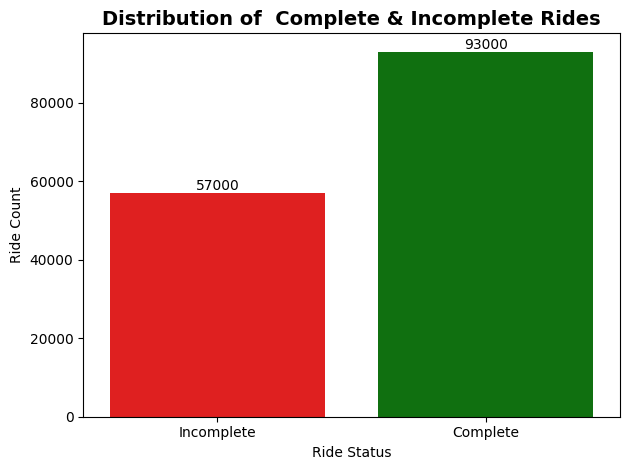

In [14]:
ax=sb.countplot(data=df,x='Ride_status',hue='Ride_status',palette={'Incomplete':'Red','Complete':'Green'})
plt.title('Distribution of  Complete & Incomplete Rides',fontweight='bold',fontsize=14)
plt.xlabel('Ride Status')
plt.ylabel('Ride Count')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
plt.tight_layout()

In [15]:
reason_counts = df['incomplete_ride_reason'].value_counts()
print(reason_counts.head(10))

incomplete_ride_reason
Not Applicable                         93000
Unknown                                10500
Customer related issue                  6837
The customer was coughing/sick          6751
Personal & Car related issues           6726
More than permitted people in there     6686
Customer Demand                         3040
Vehicle Breakdown                       3012
Other Issue                             2948
Wrong Address                           2362
Name: count, dtype: int64


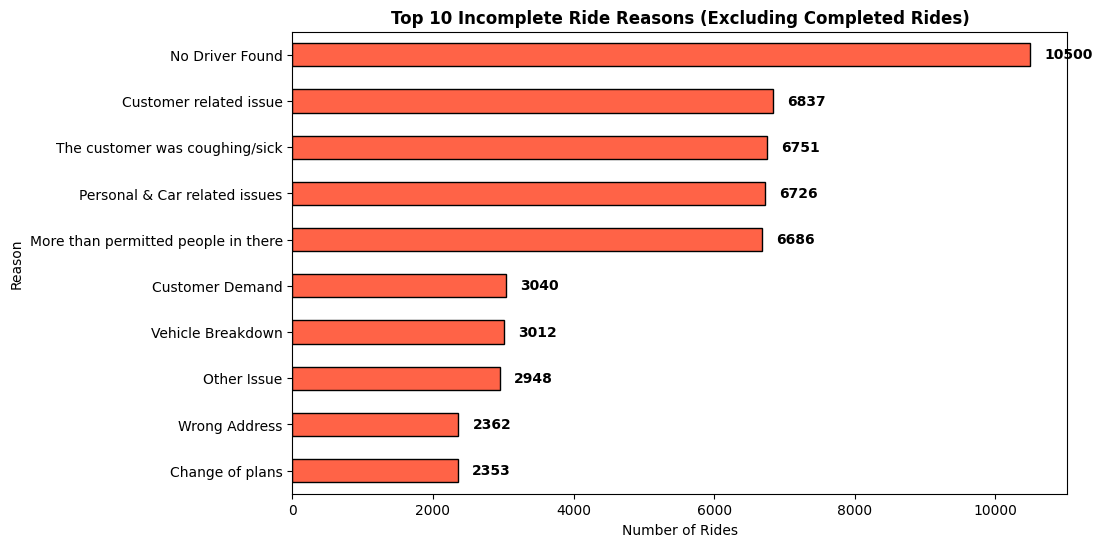

In [16]:
df['incomplete_ride_reason'] =df['incomplete_ride_reason'].replace({'Unknown':'No Driver Found'})
filtered = df[df['incomplete_ride_reason'] != "Not Applicable"]
# Count top reasons
top_reasons = filtered['incomplete_ride_reason'].value_counts().head(10)
# Plot
plt.figure(figsize=(10,6))
top_reasons.sort_values().plot(kind='barh', color='tomato', edgecolor='black')

plt.title("Top 10 Incomplete Ride Reasons (Excluding Completed Rides)", fontsize=12, fontweight='bold')
plt.xlabel("Number of Rides")
plt.ylabel("Reason")
for index, value in enumerate(top_reasons.sort_values()):
    plt.text(value + 200, index, str(value), va='center', fontsize=10, fontweight='bold')  
plt.show()

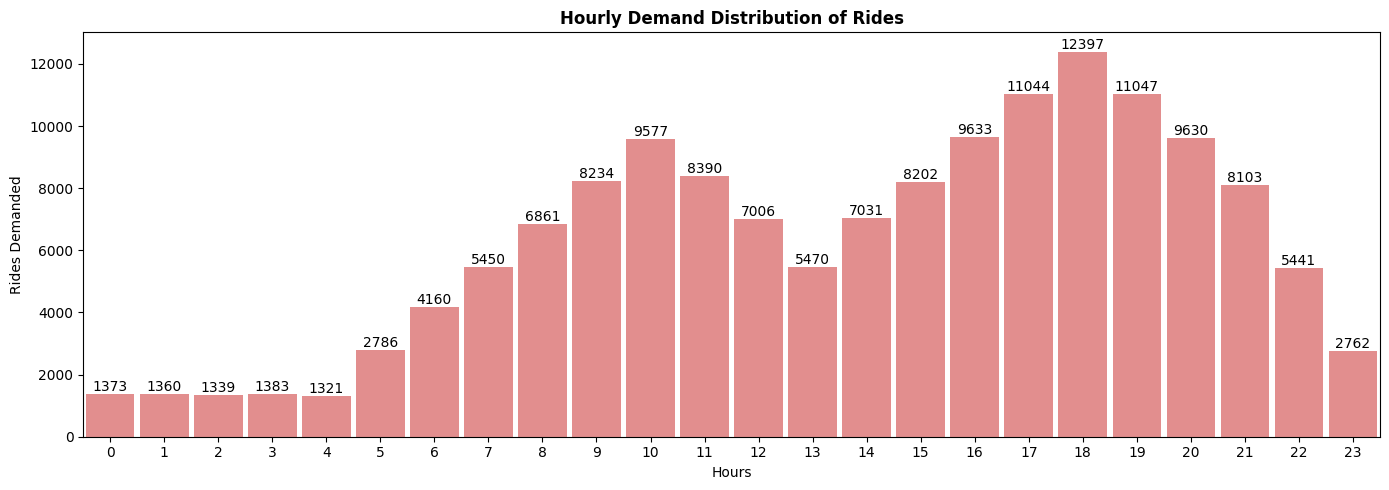

In [17]:
plt.figure(figsize=(14,5))
ax=sb.countplot(data=df,x='Hour',color='lightcoral',width=0.9)
plt.title('Hourly Demand Distribution of Rides',fontweight='bold',fontsize=12)
plt.xlabel('Hours')
plt.ylabel('Rides Demanded')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
plt.tight_layout()
plt.show()


Demand for rides is lowest around early morning hours and peaks sharply between 18:00 and 19:00, indicating the highest ride requests occur in the early evening.



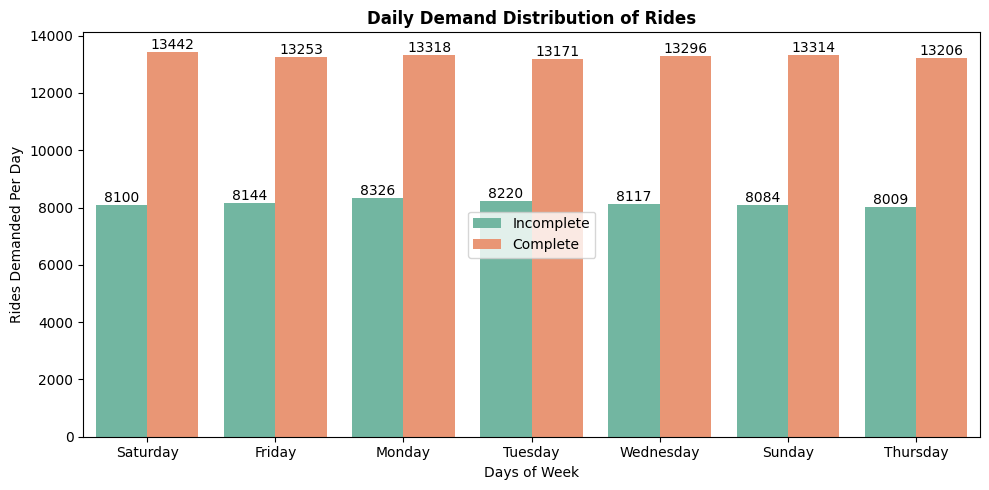

In [18]:
plt.figure(figsize=(10,5))
ax=sb.countplot(data=df,x='Day_Name',hue='Ride_status',palette='Set2')
plt.title('Daily Demand Distribution of Rides',fontweight='bold',fontsize=12)
plt.xlabel('Days of Week')
plt.ylabel('Rides Demanded Per Day')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
plt.tight_layout()
plt.legend(loc='center')
plt.show()

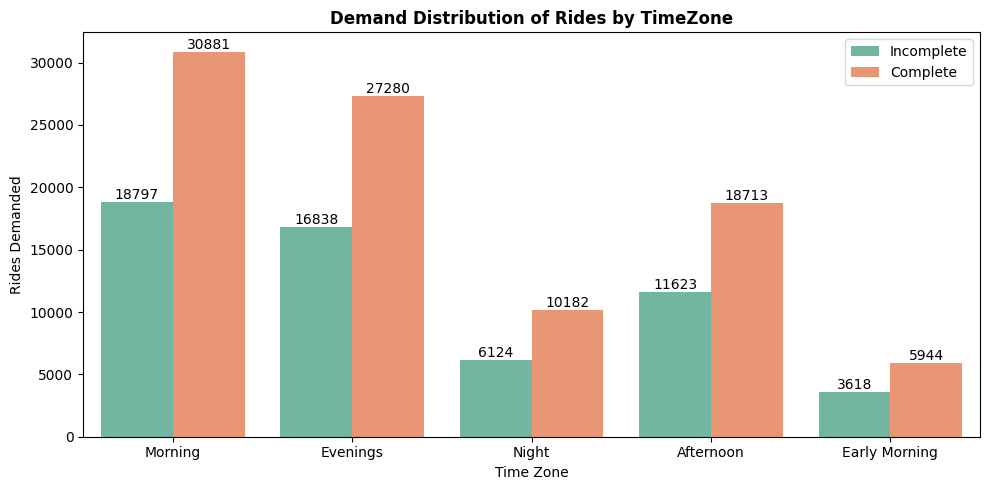

In [19]:
plt.figure(figsize=(10,5))
ax=sb.countplot(data=df,x='TimeZone',hue='Ride_status',palette='Set2')
plt.title('Demand Distribution of Rides by TimeZone',fontweight='bold',fontsize=12)
plt.xlabel('Time Zone')
plt.ylabel('Rides Demanded')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

Completed rides consistently outnumber incomplete rides across all days of the week, with each day showing a similar pattern of demand.

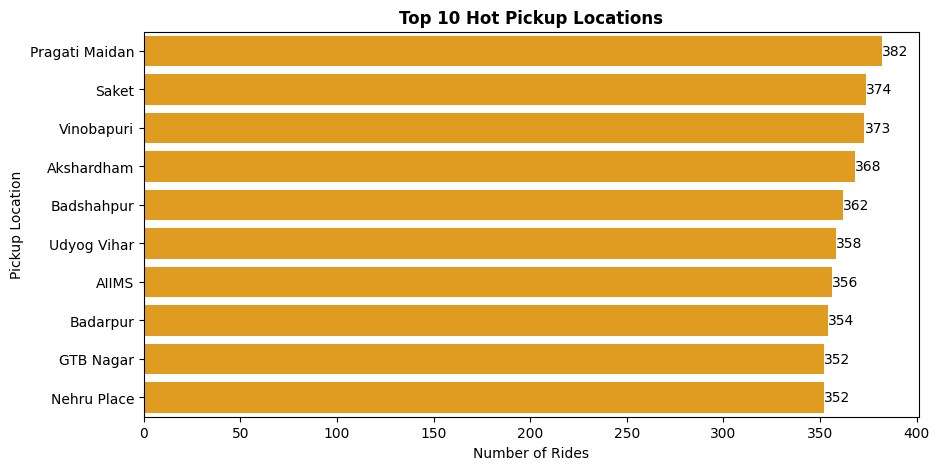

In [20]:
top_pickup_locations = filtered['Pickup Location'].value_counts().head(10)
top_pickup_locations = top_pickup_locations.sort_values(ascending=False)  # Sort for horizontal bar order

plt.figure(figsize=(10, 5))
ax = sb.barplot(x=top_pickup_locations.values, y=top_pickup_locations.index,color='orange')
plt.title("Top 10 Hot Pickup Locations", fontsize=12, fontweight='bold')
plt.xlabel("Number of Rides")
plt.ylabel("Pickup Location")
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
plt.show()

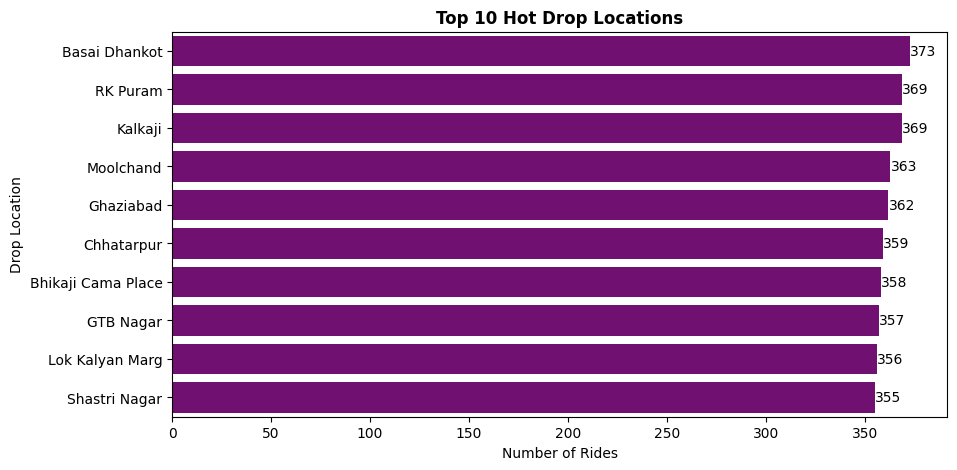

In [21]:
top_drop_locations = filtered['Drop Location'].value_counts().head(10)
top_drop_locations = top_drop_locations.sort_values(ascending=False)  # Sort for horizontal bar order

plt.figure(figsize=(10, 5))
ax = sb.barplot(x=top_drop_locations.values, y=top_drop_locations.index, color='purple')
plt.title("Top 10 Hot Drop Locations", fontsize=12, fontweight='bold')
plt.xlabel("Number of Rides")
plt.ylabel("Drop Location")
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
plt.show()

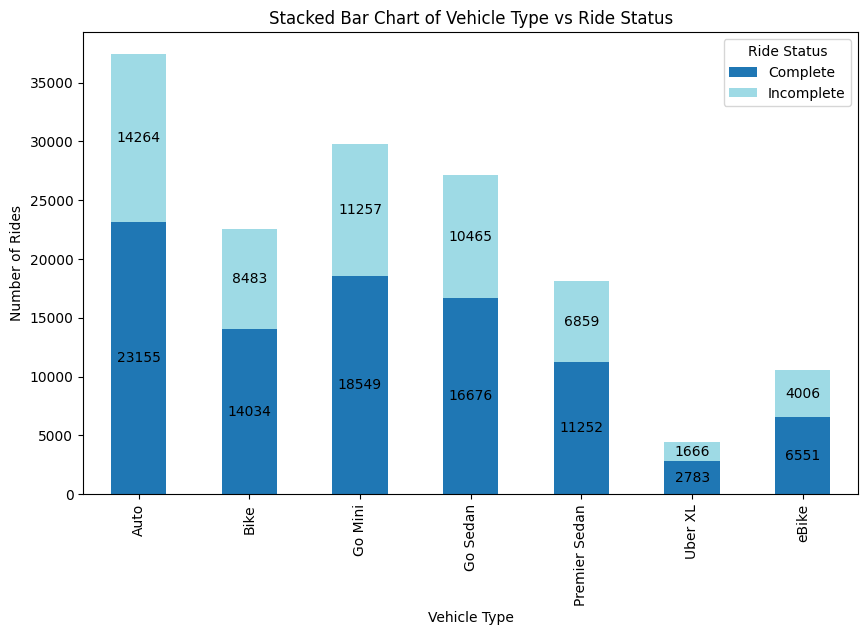

In [22]:
stacked_data = pd.crosstab(df['Vehicle Type'], df['Ride_status'])

# Plot stacked bar chart
ax=stacked_data.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.ylabel('Number of Rides')
plt.title('Stacked Bar Chart of Vehicle Type vs Ride Status')
plt.legend(title='Ride Status')
plt.show()

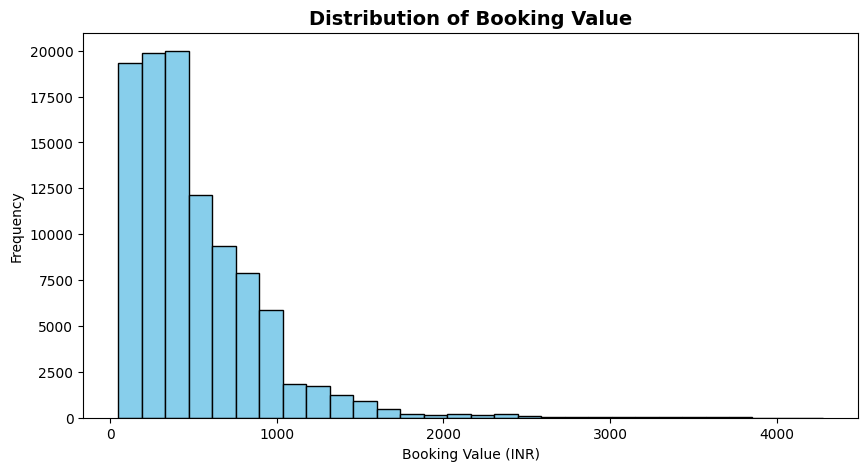

In [23]:
plt.figure(figsize=(10,5))
df['Booking Value'].dropna().plot(kind='hist',bins=30,color='skyblue',edgecolor='black')
plt.title("Distribution of Booking Value", fontsize=14, fontweight='bold')
plt.xlabel("Booking Value (INR)")
plt.ylabel("Frequency")
plt.show()

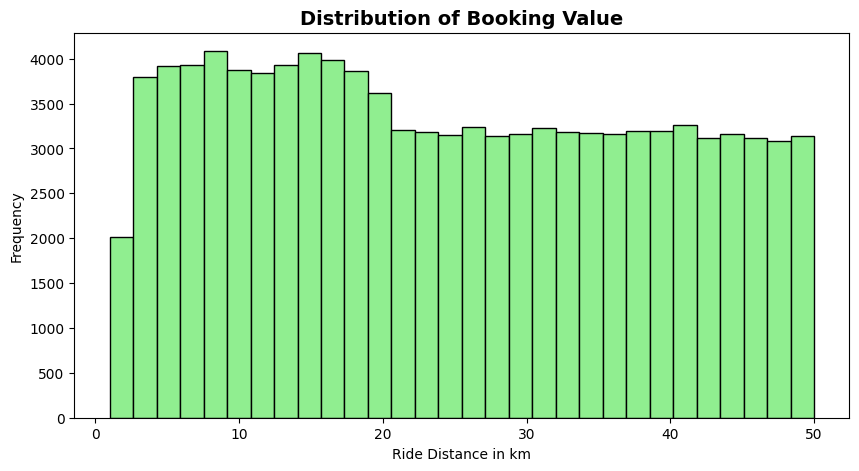

In [24]:
plt.figure(figsize=(10,5))
df['Ride Distance'].dropna().plot(kind='hist',bins=30,color='lightgreen',edgecolor='black')
plt.title("Distribution of Booking Value", fontsize=14, fontweight='bold')
plt.xlabel("Ride Distance in km")
plt.ylabel("Frequency")
plt.show()

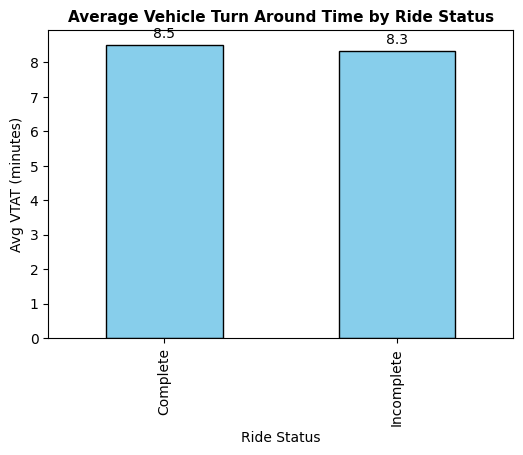

In [25]:
avg_vtat = df.groupby('Ride_status')['Avg VTAT'].mean()

plt.figure(figsize=(6,4))
avg_vtat.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Average Vehicle Turn Around Time by Ride Status", fontsize=11, fontweight='bold')
plt.xlabel("Ride Status")
plt.ylabel("Avg VTAT (minutes)")

# Add value labels
for i, v in enumerate(avg_vtat):
    plt.text(i, v + 0.2, round(v, 1), ha='center', fontsize=10)

plt.show()


In [28]:
df.to_csv("Uber NCR Bookings Clean.csv")